### Paper infographic ###

Creating a simple infographic showing where we have skill for different variables.

Intending to show:

* Electricity demand skill for the UK (pylon/lightbulb)
* Solar power capacity factor skill over Spain (solar panel)
* Wind power generation skill over the North Sea (wind turbine)
* Precipitation skill over Scandinavia (rain drop)

In [1]:
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox, AnchoredText)
import matplotlib.pyplot as plt
import matplotlib.image as image
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.io.shapereader import Reader
from cartopy.io.shapereader import natural_earth
from shapely.geometry import shape

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# import dictionaries
import dictionaries_em as dicts

In [3]:
# Load in the shapefile fo the eez data
EEZ_shapefile = Reader("/home/users/benhutch/shapefiles/EEZ/eez_v12.shp")

# # Throw away all of the columns, apart from "GEONAME", 'SOVEREIGN1',
# # "ISOSOV1", "geometry"
# EEZ_shapefile = EEZ_shapefile[["GEONAME", "SOVEREIGN1", "ISO_SOV1", "geometry"]]

In [4]:
# print the head of the eez shapefile
boundaries = EEZ_shapefile.records()

In [5]:
# # subset the shapefile to only include the eez_agg_countries
# # where ISO_SOV1 is in the list of eez_agg_countries
# eez_shapefile = EEZ_shapefile[EEZ_shapefile["ISO_SOV1"].isin(dicts.eez_agg_countries)]


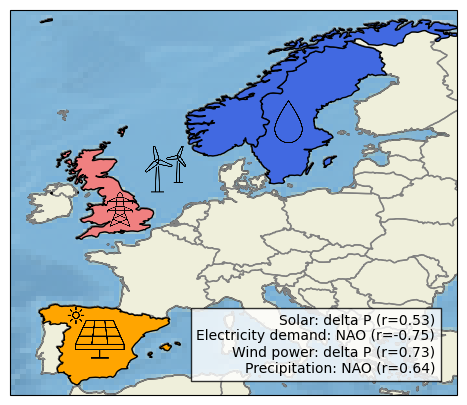

In [9]:
from shapely.geometry import shape, MultiPolygon
from shapely.ops import unary_union

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-12, 31, 35, 72], crs=ccrs.PlateCarree())
ax.stock_img()

rain_path = "/home/users/benhutch/energy-met-corr/images/rain.png"
pylon_path = "/home/users/benhutch/energy-met-corr/images/pylon.png"
solar_path = "/home/users/benhutch/energy-met-corr/images/solar.png"
wind_path = "/home/users/benhutch/energy-met-corr/images/wind.png"

# # Add the rain image to the plot
rain = OffsetImage(image.imread(rain_path), zoom=0.14)
pylon = OffsetImage(image.imread(pylon_path), zoom=0.10)
solar = OffsetImage(image.imread(solar_path), zoom=0.14)
wind = OffsetImage(image.imread(wind_path), zoom=0.14)

# Create a feature for country borders at 1:50m from Natural Earth.
country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

# Add our states feature.
ax.add_feature(country_borders, edgecolor='gray')
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# Highlight specific countries
shapefile = natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
reader = Reader(shapefile)
countries = reader.records()

highlight_countries = {
    'United Kingdom': 'lightcoral',
    'Spain': 'orange',
    'Norway': 'royalblue',
    'Sweden': 'royalblue',
}

# Define the geometry of Northern Ireland (example coordinates)
northern_ireland_geom = MultiPolygon([shape({
    "type": "Polygon",
    "coordinates": [[
        [-8.0, 55.3], [-5.5, 55.3], [-5.5, 54.0], [-8.0, 54.0], [-8.0, 55.3]
    ]]
})])

for country in countries:
    if country.attributes['NAME'] in highlight_countries:
        geom = shape(country.geometry)
        
        # If the country is the United Kingdom, subtract Northern Ireland
        if country.attributes['NAME'] == 'United Kingdom':
            geom = geom.difference(northern_ireland_geom)
        
        # # Print geom for debugging
        # print(geom)
        
        ax.add_geometries([geom], ccrs.PlateCarree(),
                          facecolor=highlight_countries[country.attributes['NAME']],
                          edgecolor='black')
        
# Add the rain image to the plot at a specific location
ab = AnnotationBbox(rain, (13, 54), frameon=False, xycoords='data', boxcoords="offset points", pad=0.5)
ax.add_artist(ab)

# add the solar over spain
ab = AnnotationBbox(solar, (-3.3, 36), frameon=False, xycoords='data', boxcoords="offset points", pad=0.5)
ax.add_artist(ab)

# add the wind over the NOrth Sea
ab = AnnotationBbox(wind, (2.6, 50), frameon=False, xycoords='data', boxcoords="offset points", pad=0.5)
ax.add_artist(ab)

# add the pylon over the UK
ab = AnnotationBbox(pylon, (-1.3, 46.6), frameon=False, xycoords='data', boxcoords="offset points", pad=0.5)
ax.add_artist(ab)

# # print all of the boundaries
# for boundary in boundaries:
#     if boundary.attributes["ISO_SOV1"] in dicts.eez_agg_countries:
#         geoname = boundary.attributes["GEONAME"]
#         if "Exclusive Economic Zone" in geoname and "(" not in geoname and ")" not in geoname:
#             # # print the iso code
#             # print(boundary.attributes["ISO_SOV1"])
#             # # print the geoname
#             # print(boundary.attributes["GEONAME"])
#             geom = shape(boundary.geometry)
#             ax.add_geometries([geom], ccrs.PlateCarree(),
#                               facecolor='dodgerblue',
#                               edgecolor='none')

# Add a text annotation for the license information to the bottom right corner.
# text = AnchoredText('\u00A9 {}; license: {}'
#                     ''.format(SOURCE, LICENSE),
#                     loc=4, prop={'size': 12}, frameon=True)
# ax.add_artist(text)
            
plt.text(0.95, 0.05, '''Solar: delta P (r=0.53)
Electricity demand: NAO (r=-0.75)
Wind power: delta P (r=0.73)
Precipitation: NAO (r=0.64)''',
         verticalalignment='bottom', horizontalalignment='right',
         transform=ax.transAxes,
         color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# set up a name for the figure
fig_name = "/home/users/benhutch/energy-met-corr/images/eez_map.pdf"

# save the figure as a pdf with a high dpi
fig.savefig(fig_name, bbox_inches='tight', dpi=600)